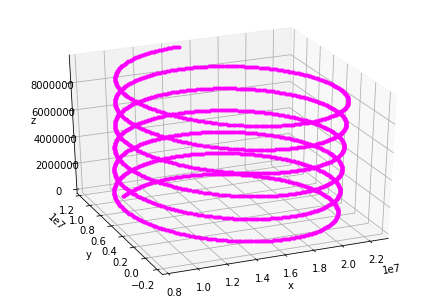


 Parameter            Value
-------------  -----------
Max. distance  2.5043e+07
Avg. distance  1.79977e+07
Max. speed     1.41421e+07
Avg. speed     1.41421e+07


In [2]:
"""
Bouncing particles, refactored
Srayan Gangopadhyay
2020-06-17
"""

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from IPython.display import HTML, display  # show anim. in ntbk
from tabulate import tabulate  # pretty text output
from datetime import datetime  # timestamp for output files
from tqdm.auto import tqdm  # progress bar

# CONSTANTS
m_pr = 1.67e-27  # proton mass (kg)
m_el = 9.109e-31  # electron mass (kg)
e = 1.602e-19  # elementary charge (C)
Re = 6.37e6  # Earth radius (m)

# PARAMETERS
r0 = [1e7,1e7, 0]  # initial position
v0 = [1e7, 1e7, 0]  # initial velocity
q = e  # charge
m = m_pr  # mass
h = 0.01  # step size
end = 20  # t-value to stop integration
size = [np.inf, np.inf, np.inf]  # simulation dimensions
frames = 100  # for animation
anim = False  # switch animation on/off
tableprint = True  # switch textout on/off
export = False  # switch data dump on/off

def B_field(r):
    """Returns the components of the magnetic
    field, given a 3D position vector."""
    return [1e-9, 1e-16, 2e-8]

def E_field(r):
    """Returns the components of the electric
    field, given a 3D position vector."""
    return [0,0,0]

def lorentz(r, vel, E, B):
    """The Lorentz force equation. Returns
    acceleration of particle given its
    position, velocity, E field
    function, and B field function."""
    return (q/m)*(E(r) + np.cross(vel, B(r)))

def rk4(func, init1, init2, h, end):
    """Takes the RHS of a 2nd-order ODE with initial conditions,
    step size and end point, and integrates using the 4th-order
    Runge-Kutta algorithm. Returns solution in an array.

    r'' = f(t, r, v) where v = r'

    func: the function to be integrated
    init1: value of r at t=0
    init2: value of v at t=0
    h: step size
    end: t-value to stop integrating
    """
    steps = int(end/h)  # number of steps
    r = np.zeros((3, steps))  # empty matrix for solution
    v = np.zeros((3, steps))
    r[:,0] = init1  # inserting initial value
    v[:,0] = init2

    for i in tqdm(range(0, steps-1), desc='Integrating'):
        k1r = h * v[:,i]
        k1v = h * func(r[:,i], v[:,i], E_field, B_field)
        k2r = h * (v[:,i] + 0.5*k1v)
        k2v = h * func(r[:,i], v[:,i] + 0.5*k1v, E_field, B_field)
        k3r = h * (v[:,i] + 0.5*k2v)
        k3v = h * func(r[:,i], v[:,i] + 0.5*k2v, E_field, B_field)
        k4r = h * (v[:,i] + k3v)
        k4v = h * func(r[:,i], v[:,i] + k3v, E_field, B_field)
        new_r = r[:,i] + (k1r + 2*k2r + 2*k3r + k4r) / 6
        new_v = v[:,i] + (k1v + 2*k2v + 2*k3v + k4v) / 6
        
        if (new_r[0] < size[0]*-0.5):  # stop particle leaving box
            new_r[0] += size[0]        # TODO: is there a neater way?
        if (new_r[0] >= size[0]*0.5):
            new_r[0] -= size[0]
        if (new_r[1] < size[1]*-0.5):
            new_r[1] += size[1]
        if (new_r[1] >= size[1]*0.5):
            new_r[1] -= size[1]
        if (new_r[2] < size[2]*-0.5):
            new_r[2] += size[2]
        if (new_r[2] >= size[2]*0.5):
            new_r[2] -= size[2]
            
        r[:,i+1] = new_r
        v[:,i+1] = new_v
    return r, v

def calcmod(r, v):
    """Calculates modulus of vectors."""
    distances = np.linalg.norm(r, axis=0)
    speeds = np.linalg.norm(v, axis=0)
    return distances, speeds

def printout(r, v):
    """Prints out basic stats in table
    form."""
    distances, speeds = calcmod(r, v)
    print("\n",tabulate([['Max. distance', np.amax(distances)], 
                     ['Avg. distance', np.mean(distances)], 
                     ['Max. speed', np.amax(speeds)], 
                     ['Avg. speed', np.mean(speeds)]], 
                    headers=['Parameter', 'Value']))

def textout(r, v):
    """Exports raw data to .csv file."""
    distances, speeds = calcmod(r, v)
    filename = (datetime.now()
                .strftime("%Y%m%d-%H%M%S") + "_data.csv")
    with open(filename, 'a') as f:
        f.write("r-vectors\n")
        np.savetxt(f, r, delimiter=",")
        f.write("\nv-vectors\n")
        np.savetxt(f, v, delimiter=",")
        f.write("\ndistances\n")
        np.savetxt(f, distances[None], delimiter=",")
        f.write("\nspeeds\n")
        np.savetxt(f, speeds[None], delimiter=",")
    print("\nExported full data to ",filename)

def plotsetup(r):
    """Creates a figure and set of axes
    ready for plotting/animation."""
    fig = plt.figure()  # generate a figure
    ax = Axes3D(fig)  # set up 3d axes
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.view_init(30, -113)  # change viewing angle
    ax.set_xlim3d(np.amin(r[0]), np.amax(r[0]))  # auto-scale axes
    ax.set_ylim3d(np.amin(r[1]), np.amax(r[1]))
    ax.set_zlim3d(np.amin(r[2]), np.amax(r[2]))
    return (fig, ax)

def animate(i, ax, r, pbar):
    """Called by FuncAnimation to plot each frame."""
    j = 100*i  # to skip frames and change animation speed
    ax.plot3D(r[0, :j], r[1, :j], r[2, :j], '.', color='magenta')
    pbar.update(1)  # increment progress bar
    
def plot_or_anim(r, frames, fig, ax):
    if not anim:
        ax.plot3D(r[0], r[1], r[2], '.', color='magenta')
        plt.show()
    else:
        global pbar
        pbar = tqdm(total=int(end/h), desc='Animating')  # start progress bar
        animat = animation.FuncAnimation(fig, animate, fargs=(ax, r, pbar),
                                         frames=int(end/h), interval=50, 
                                         blit=False, repeat=False)
        display(HTML(animat.to_html5_video()))
        pbar.close()  # close progress bar

def main():
    r, v = rk4(lorentz, r0, v0, h, end)  # call the integrator
    plot_or_anim(r, frames, *plotsetup(r))
    if tableprint: printout(r, v)
    if export: textout(r, v)

if __name__ == "__main__":
    main()